# Meta-Learner Benchmarks with Semi-synthetic Data in Schuler, A., Jung, K., Tibshirani, R., Hastie, T., and Shah, N. Synth-validation: Selecting the best causal inference method for a given dataset (2017)

This notebook compares X-, R-, and T learners using the Constrained gradient boosting semi synthetic framework described in  [Schuler, A., Jung, K., Tibshirani, R., Hastie, T., and Shah, N (2017)](https://arxiv.org/pdf/1711.00083) using the IHDP dataset.

In [1]:
import numpy as np
import pandas as pd

from causalml.inference.meta import BaseTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor

from causalml.dataset.semiSynthetic import SemiSynthDataGenerator

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, Lasso

from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

/Users/iyarlin/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import importlib
print(importlib.metadata.version('causalml') )

0.15.5


In [3]:
data = pd.read_csv('data/ihdp_npci_8.csv', header=None)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [str(i) for i in range(25)]
data.columns = cols

X = data[[str(i) for i in range(5)]]
y = data["y_factual"]
w = data["treatment"]

In [4]:
class NaiveLearner():
    def _init_(self):
        pass
    def fit(self, X, treatment, y):
        self.ate = y[treatment==1].mean() - y[treatment==0].mean()
    def predict(self, X, p):
        return np.repeat(self.ate, len(X))  
    def estimate_ate(self, X, treatment, y):
        ate = y[treatment==1].mean() - y[treatment==0].mean()
        return [ate] # No need for CI right now

In [5]:
def run_experiments(X, w, y, learner_dict, propensity_learner, K=10, n=None, **data_generator_kwargs):
    
    synth_gen = SemiSynthDataGenerator(**data_generator_kwargs)
    synth_gen.fit(X, w, y)   
    datasets = synth_gen.generate(K=K, n=n)
    result_list = []

    for q in range(len(datasets)):
        for k in range(len(datasets[q])):
            X = datasets[q][k][[str(i) for i in range(5)]]
            w = datasets[q][k]['w']
            y = datasets[q][k]['y']
            tau_i = datasets[q][k]['tau_i']
            X_train, X_test, w_train, _, y_train, _, _, tau_test = train_test_split(
                X, w, y, tau_i, test_size=0.2, random_state=111)

            em = clone(propensity_learner)
            em.fit(X_train, w_train)
            e_hat_test = em.predict_proba(X_test)[:, 1]
            
            for learner in learner_dict.keys():
                model = deepcopy(learner_dict[learner])
                model.fit(X = X_train, treatment = w_train, y = y_train)
                hat_tau = model.predict(X_test, p=e_hat_test)
                pehe = mean_squared_error(tau_test, hat_tau)
                result_list.append([q, k, learner, pehe])
    
    cols = ['q', 'k', 'learner', 'pehe']
    df_res = pd.DataFrame(result_list, columns=cols)
    return df_res

## Lasso based experiments

In [6]:
learner_dict = {
    'Naive-Learner': NaiveLearner(),
    'T-Learner': BaseTRegressor(learner=Lasso()),
    'X-Learner': BaseXRegressor(learner=Lasso()),
    'R-Learner': BaseRRegressor(learner=Lasso())
}

propensity_learner = LogisticRegression(penalty='l1', solver='liblinear')
df_res_lasso = run_experiments(X, w, y, learner_dict, propensity_learner, Q = 5, B=1, n = 10000)

Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed t

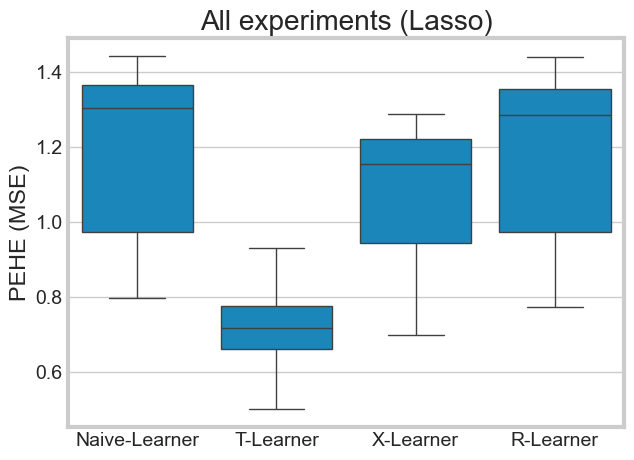

In [7]:
sns.boxplot(x='learner', y='pehe', data=df_res_lasso, linewidth=1, showfliers=False)
plt.ylabel('PEHE (MSE)')
plt.xlabel('')
plt.title('All experiments (Lasso)')
plt.show()

The paper discusses benchmarking ATE esimation so let's do that as well:

In [8]:
def run_experiments2(X, w, y, learner_dict, K=10, n = None, **data_generator_kwargs):
    
    synth_gen = SemiSynthDataGenerator(**data_generator_kwargs)
    synth_gen.fit(X, w, y)   
    datasets = synth_gen.generate(K=K, n=n)
    result_list = []

    for q in range(len(datasets)):
        for k in range(len(datasets[q])):
            X = datasets[q][k][[str(i) for i in range(5)]]
            w = datasets[q][k]['w']
            y = datasets[q][k]['y']
            tau_i = datasets[q][k]['tau_i']
            
            X_train, X_test, w_train, _, y_train, _, _, tau_test = train_test_split(
                X, w, y, tau_i, test_size=0.2, random_state=111)

            true_ate = tau_test.mean()

            for learner in learner_dict.keys():
                model = deepcopy(learner_dict[learner])
                ate_hat = float(model.estimate_ate(X = X_train, treatment = w_train, y = y_train)[0])
                ate_diff = np.abs(ate_hat - true_ate)
                result_list.append([q, k, learner, ate_diff, true_ate])
    
    cols = ['q', 'k', 'learner', 'ate_diff', 'true_ate']
    df_res = pd.DataFrame(result_list, columns=cols)
    return df_res

In [9]:
learner_dict = {
    'Naive-Learner': NaiveLearner(),
    'T-Learner': BaseTRegressor(learner=Lasso()),
    'X-Learner': BaseXRegressor(learner=Lasso()),
    'R-Learner': BaseRRegressor(learner=Lasso())
}

df_res_lasso2 = run_experiments2(X, w, y, learner_dict, Q = 5, B=1, n = 10000)

Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed to import duecredit due to No module named 'duecredit'
Failed t

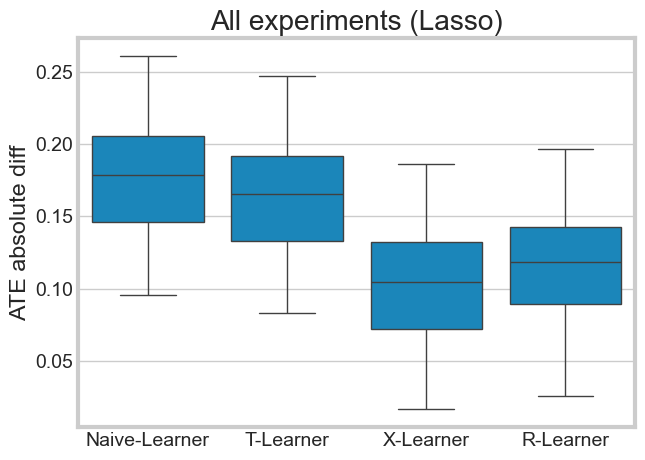

In [10]:
sns.boxplot(x='learner', y='ate_diff', data=df_res_lasso2, linewidth=1, showfliers=False)
plt.ylabel('ATE absolute diff')
plt.xlabel('')
plt.title('All experiments (Lasso)')
plt.show()